## Accessibility charts per admin unit

Visualizing our results. This notebook is prepared in R format because I prefer charting in R

In [1]:
library(dplyr)
library(ggplot2)
library(gridExtra) 

library(ggtext)
library(showtext)
library(extrafont)
library(scales)
library(grid)
library(stringr)



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Loading required package: sysfonts

Loading required package: showtextdb

Registering fonts with R


Attaching package: 'extrafont'


The following object is masked from 'package:showtextdb':

    font_install




In [2]:
## Loading Google fonts (https://fonts.google.com/)
font_add_google("Gochi Hand", "gochi")
font_add_google("Schoolbell", "bell")

In [3]:
font_add(family="Gill Sans MT",regular="C:\\windows\\Fonts\\GIL_____.TTF")
font_add(family="Proxima Nova",regular="C:\\windows\\Fonts\\ProximaNova-Regular.otf")
font_add(family="Roboto",regular="C:\\windows\\Fonts\\Roboto-Regular.ttf")

In [4]:
showtext_auto()

## Setup

**Files and variables**

Today's date

In [5]:
# today = date.today().strftime("%d%m%y")

Directories

In [6]:
geo_dir <- "P:\\PAK\\GEO"
data_dir <- "..\\..\\data"

rast_dir <- "rast_inputs"
vect_in_dir <- "vect_inputs"
vect_out_dir <- "vect_out"

rds_dir <- "roads"
dest_dir <- "destinations"
speed_dir <- "speed"
fric_dir <- "friction"
acc_dir <- "access"
tab_dir <- "tabular"

plot_dir <- "\\charts"

Load in data

In [7]:
#master
accmast_adm3 <- read.csv(file.path(data_dir,tab_dir,'final//adm3_access_all_w_sensitivity.csv'),header=TRUE)
accmast_adm3_long <- read.csv(file.path(data_dir,tab_dir,'final//adm3_master_access_stats_long.csv'),header=TRUE)

In [8]:
# # mean
accm_adm2 <- read.csv(file.path(data_dir,tab_dir,'final//adm2_focus_access_aggregates.csv'),header=TRUE)
accm_adm3 <- read.csv(file.path(data_dir,tab_dir,'final//adm3_focus_access_aggregates.csv'),header=TRUE)

# # standard deviation
# acc_sd_adm2 <- read.csv(file.path(data_dir,tab_dir,'final//adm2_sd_211008.csv'),header=TRUE)
# acc_sd_adm3 <- read.csv(file.path(data_dir,tab_dir,'final//adm3_sd_211008.csv'),header=TRUE)

# long
accl_adm2 <- read.csv(file.path(data_dir,tab_dir,'final//adm2_acc_indicators_long.csv'),header=TRUE)
accl_adm3 <- read.csv(file.path(data_dir,tab_dir,'final//adm3_acc_indicators_long.csv'),header=TRUE)

## Data cleanup and prep

In [9]:
# create Adm2 Code for Adm3 data
# accm_adm3$Adm2_Code <- factor(substr(accm_adm3$Adm3_Code, 1, 5))
# accl_adm3$Adm2_Code <- factor(substr(accl_adm3$Adm3_Code, 1, 5))

In [10]:
# Factor columns that should be such

accl_adm2$Adm2_Code <- as.factor(accl_adm2$Adm2_Code)
accm_adm2$Adm2_Code <- as.factor(accm_adm2$Adm2_Code)

accl_adm3$Adm3_Code <- as.factor(accl_adm3$Adm3_Code)
accm_adm3$Adm3_Code <- as.factor(accm_adm3$Adm3_Code)

accl_adm2$indicator <- as.factor(accl_adm2$indicator)
accl_adm3$indicator <- as.factor(accl_adm3$indicator)

In [11]:
# Arrange travel time ranges correctly
accl_adm2$travel_time_range <- factor(accl_adm2$travel_time_range, levels = c("0 - 30 minutes","31 - 60 minutes","1 - 2 hours","2 - 4 hours","4 - 8 hours","8 - 16 hours","16+ hours"))
accl_adm3$travel_time_range <- factor(accl_adm3$travel_time_range, levels = c("0 - 30 minutes","31 - 60 minutes","1 - 2 hours","2 - 4 hours","4 - 8 hours","8 - 16 hours","16+ hours"))

In [12]:
accl_adm2 <- arrange(accl_adm2,Adm2_Code,indicator,travel_time_range)
accl_adm3 <- arrange(accl_adm3,Adm3_Code,indicator,travel_time_range)

Prep lists of admins for looping

In [14]:
adm2s <- levels(accl_adm3[,"Adm2_Code"])
adm3s <- levels(accl_adm3[,"Adm3_Code"])

Make population totals round, with commas

In [15]:
accl_adm2$pop_total <- prettyNum(round(accl_adm2$pop_total,digits=0),big.mark=",",scientific=FALSE) # make population round with commas
accl_adm3$pop_total <- prettyNum(round(accl_adm3$pop_total,digits=0),big.mark=",",scientific=FALSE) # make population round with commas


In [16]:
accl_adm2$pop_total_csum <- prettyNum(round(accl_adm2$pop_total_csum,digits=0),big.mark=",",scientific=FALSE) # make population round with commas
accl_adm3$pop_total_csum <- prettyNum(round(accl_adm3$pop_total_csum,digits=0),big.mark=",",scientific=FALSE) # make population round with commas

#### Join in additional data

Agricultural data

In [17]:
# mean
# agr_adm3 <- read.csv(file.path(data_dir,tab_dir,'KP_Tehsil_Agricultural_Areas.csv'),header=TRUE)

In [18]:
accmast_adm3$total_agr_sqkm <- accmast_adm3$orch_sqkm + accmast_adm3$irrig_sqkm + accmast_adm3$non_irrig_sqkm
accmast_adm3$total_agr_pct <- accmast_adm3$orch_pct + accmast_adm3$irrig_pct + accmast_adm3$non_irrig_pct

Terrain Roughness Index

In [79]:
adm3_TRI <- read.csv(file.path(data_dir,tab_dir,'processed//adm3_TRI.csv'),header=TRUE)

In [81]:
accmast_adm3 <- dplyr::left_join(accmast_adm3,adm3_TRI,by=c("Adm3_Code"))

School attendance gender ratios

In [19]:
ed_rat_adm3 <- read.csv(file.path(data_dir,tab_dir,'processed//adm3_educ_gender_ratio.csv'),header=TRUE)[-c(1:2)]

In [21]:
head(ed_rat_adm3)

,Adm3_Code,Boys_schools,Girls_schools
,<chr>,<dbl>,<dbl>
1,PK20101,2.466532,3.349532
2,PK20201,10.995825,61.717757
3,PK20202,7.208704,29.551511
4,PK20301,5.600795,3.711220
5,PK20302,3.483107,9.983963
6,PK20401,5.659172,17.754070


In [23]:
accmast_adm3 <- dplyr::left_join(accmast_adm3,ed_rat_adm3,by=c("Adm3_Code"))

Prepare non-educational layers for comparison

In [37]:
accmast_adm3$non_educ_master <- (accmast_adm3$health_master + accmast_adm3$markets_master) / 2

Minor prep

In [24]:
accmast_adm3_long$Access.indicators <- as.factor(accmast_adm3_long$Access.indicators)

In [25]:
accmast_adm3_long$ADM3_EN <- as.factor(accmast_adm3_long$ADM3_EN)

## Charting

Colors

In [26]:
# diverging "red-yellow-green" colors
traffic_colors <- c("0 - 30 minutes" = 'darkgreen',
"31 - 60 minutes" = '#2ab72e',
"1 - 2 hours" = 'lightgreen',
"2 - 4 hours" = '#e3eb96',
"4 - 8 hours" = '#f4f007',
"8 -  16 hours" = '#FECC42',
"16+ hours" = '#f96a34')

# diverging dark green to pink
army_rose_colors <- c("0 - 30 minutes" = '#798234',
"31 - 60 minutes" = '#a3ad62',
"1 - 2 hours" = '#d0d3a2',
"2 - 4 hours" = '#fdfbe4',
"4 - 8 hours" = '#f0c6c3',
"8 -  16 hours" = '#DF91A3',
"16+ hours" = '#d46780')

Theme

In [27]:

col_grid <- rgb(235, 235, 235, 225, maxColorValue = 255)

theme_access <- function() {    
    theme(legend.position="bottom", legend.box="vertical",
          legend.key = element_rect(fill = "transparent", colour = "transparent"),
          legend.margin=margin(t=-5,b=-5),
          legend.text = element_text(lineheight=0.25),
          panel.background = element_blank(),
          panel.border = element_blank(),
          axis.line = element_line(color='grey30'),
          plot.margin=unit(x = c(1,1,1,1), unit='mm'),
          plot.title = element_text(family="Gill Sans MT",hjust = 0,face="bold",size=20,
                                    margin=margin(t = 5, b= 0), lineheight=0.45),
          plot.subtitle = element_text(family="Roboto",face="italic",size=12,colour="grey40"),
#           strip.text = element_text(hjust = 0),
          text = element_text(family = "Roboto",size=14),
          panel.grid.major.x = element_line(size = 0.25, linetype = 'solid',
                                colour = col_grid),
          panel.grid.major.y = element_line(size = 0.25, linetype = 'solid',
                                colour = col_grid),
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank())
}

### Admin ranking charts

Ordering

In [34]:
# order by the mean ranking from the sensitivity test
wtd_rank_order = factor(accmast_adm3_long$ADM3_EN, levels = unique(accmast_adm3_long$ADM3_EN[order(accmast_adm3_long$sens_test_rank_mode)]))

# order by the mean ranking from the sensitivity test
wtd_std_order = factor(accmast_adm3_long$ADM3_EN, levels = unique(accmast_adm3_long$ADM3_EN[order(accmast_adm3_long$sens_test_rank_std)]))

# order by the master educational value
educ_order = factor(accmast_adm3_long$ADM3_EN, levels = unique(accmast_adm3_long$ADM3_EN[order(accmast_adm3_long$educ_master,decreasing=TRUE)]))

Charting

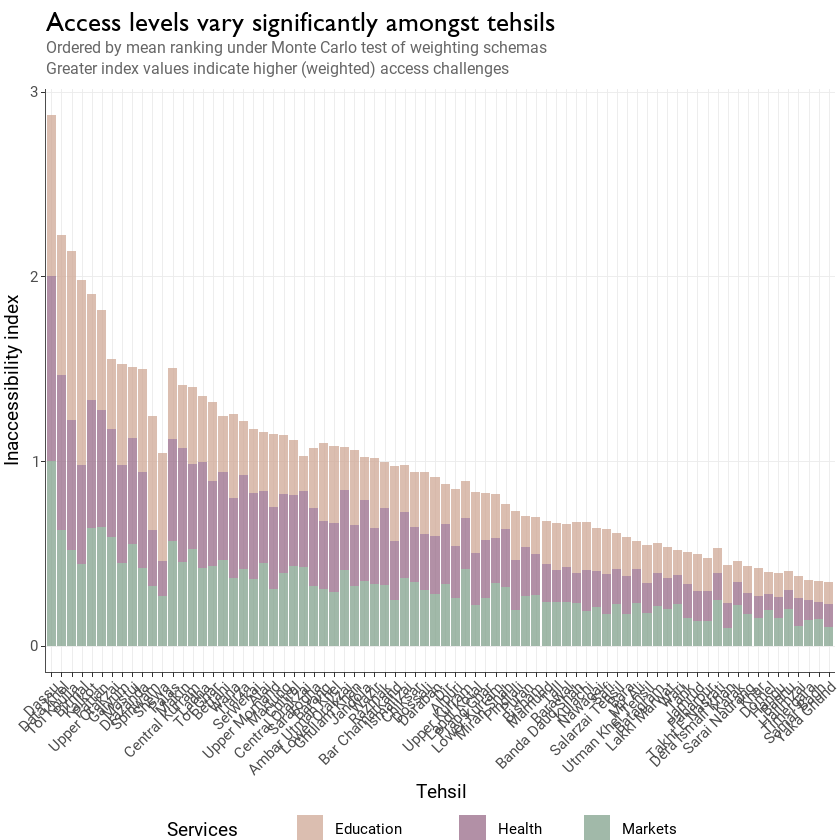

In [29]:
adm3_accmast_stackedbar <- ggplot(data = accmast_adm3_long) +
    geom_bar(aes(x=wtd_rank_order, y = Index.values, fill=Access.indicators),alpha=0.75,position="stack",stat="identity") +
    labs(x="Tehsil",y="Inaccessibility index",
         title = "Access levels vary significantly amongst tehsils", 
         subtitle = "Ordered by mean ranking under Monte Carlo test of weighting schemas\nGreater index values indicate higher (weighted) access challenges",
         fill = "Services") +
    theme_access() +
    theme(legend.margin=margin(t=-5,b=-5)) +
    scale_x_discrete(guide = guide_axis(angle=45)) +
    scale_fill_manual(labels=c("Education","Health","Markets"),values=c("#cfa895","#986b88","#82a28c"))

adm3_accmast_stackedbar
ggsave(paste(data_dir,plot_dir,"\\adm3_accmast_stackedbar.png",sep=''),width=17,height=10,units=c("cm"),dpi=200)

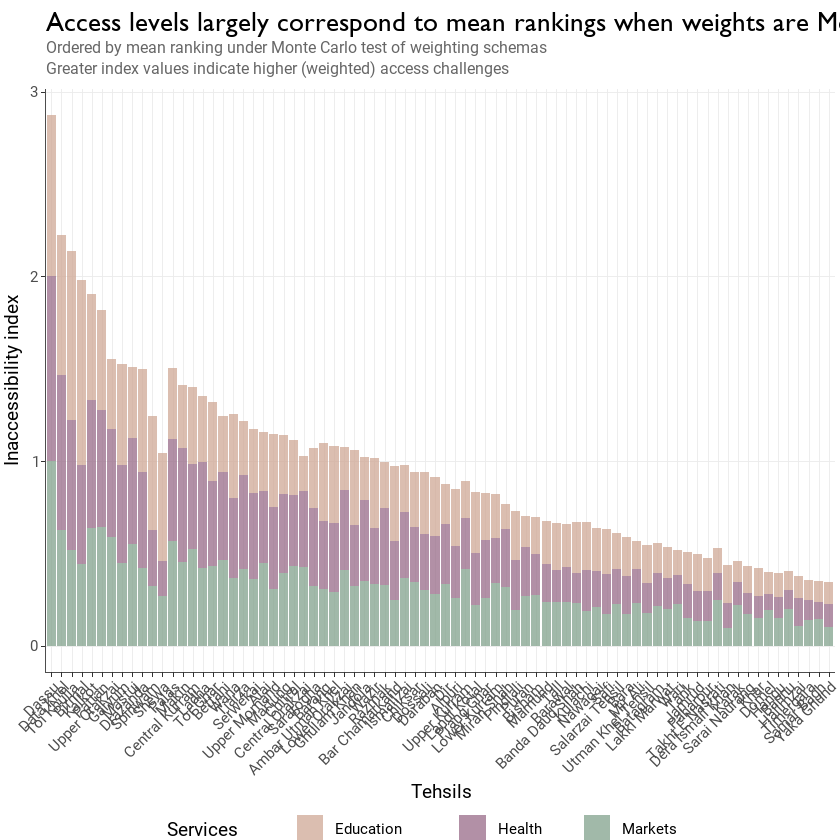

In [121]:
adm3_accmast_mean_stackedbar <- ggplot(data = accmast_adm3_long) +
    geom_bar(aes(x=wtd_rank_order, y = Index.values, fill=Access.indicators),alpha=0.75,position="stack",stat="identity") +
    labs(x="Tehsils",y="Inaccessibility index",
         title = "Access levels largely correspond to mean rankings when weights are Monte Carlo tested", 
         subtitle = "Ordered by mean ranking under Monte Carlo test of weighting schemas\nGreater index values indicate higher (weighted) access challenges",
         fill = "Services") +
    theme_access() +
    theme(legend.margin=margin(t=-5,b=-5)) +
    scale_x_discrete(guide = guide_axis(angle=45)) +
    scale_fill_manual(labels=c("Education","Health","Markets"),values=c("#cfa895","#986b88","#82a28c"))

adm3_accmast_mean_stackedbar
ggsave(paste(data_dir,plot_dir,"\\adm3_accmast_mean_stackedbar.png",sep=''),width=17,height=10,units=c("cm"),dpi=200)

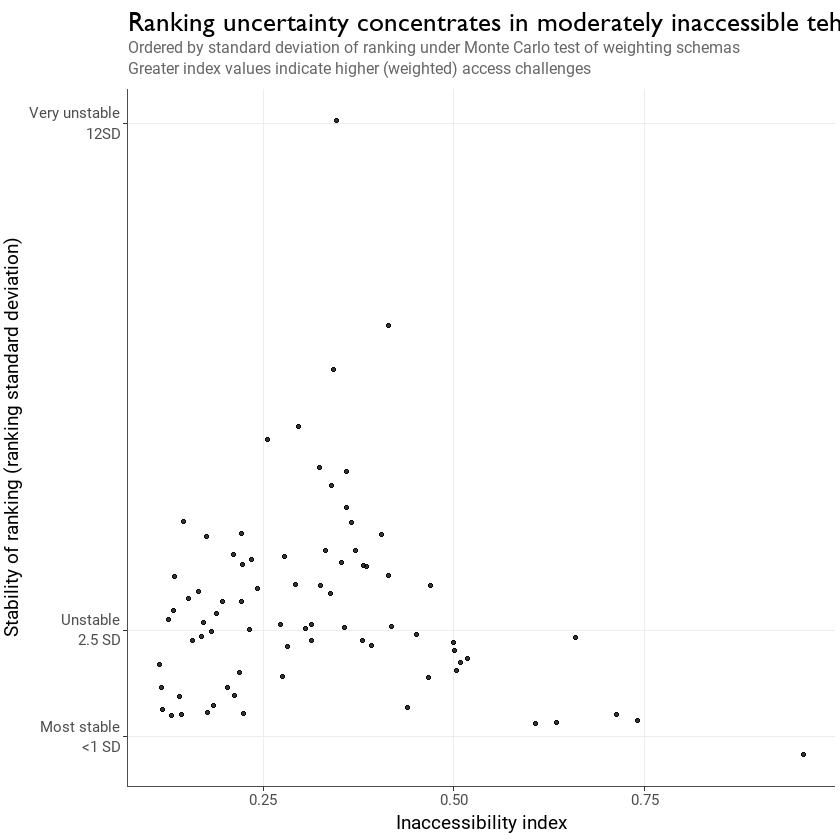

In [124]:
adm3_accmast_std_pts <- ggplot(data = accmast_adm3) +
#     geom_bar(aes(x=wtd_std_order, y = Index.values, fill=Access.indicators),alpha=0.75,position="stack",stat="identity") +
    geom_point(aes(x=eq_wt_val, y = sens_test_rank_std), alpha=0.8, size = 1) +
    labs(x="Inaccessibility index",y="Stability of ranking (ranking standard deviation)",
         title = "Ranking uncertainty concentrates in moderately inaccessible tehsils", 
         subtitle = "Ordered by standard deviation of ranking under Monte Carlo test of weighting schemas\nGreater index values indicate higher (weighted) access challenges",
         fill = "Services") +
    theme_access() +
    theme(legend.margin=margin(t=-5,b=-5)) +
#     scale_x_discrete(guide = guide_axis(angle=45)) +
    scale_y_continuous(breaks=c(0.5, 2.5, 12),
                     labels=c("Most stable\n<1 SD","Unstable\n2.5 SD","Very unstable\n 12SD"))
#     scale_fill_manual(labels=c("Education","Health","Markets"),values=c("#cfa895","#986b88","#82a28c"))

adm3_accmast_std_pts
ggsave(paste(data_dir,plot_dir,"\\adm3_accmast_std_pts.png",sep=''),width=12,height=10,units=c("cm"),dpi=200)

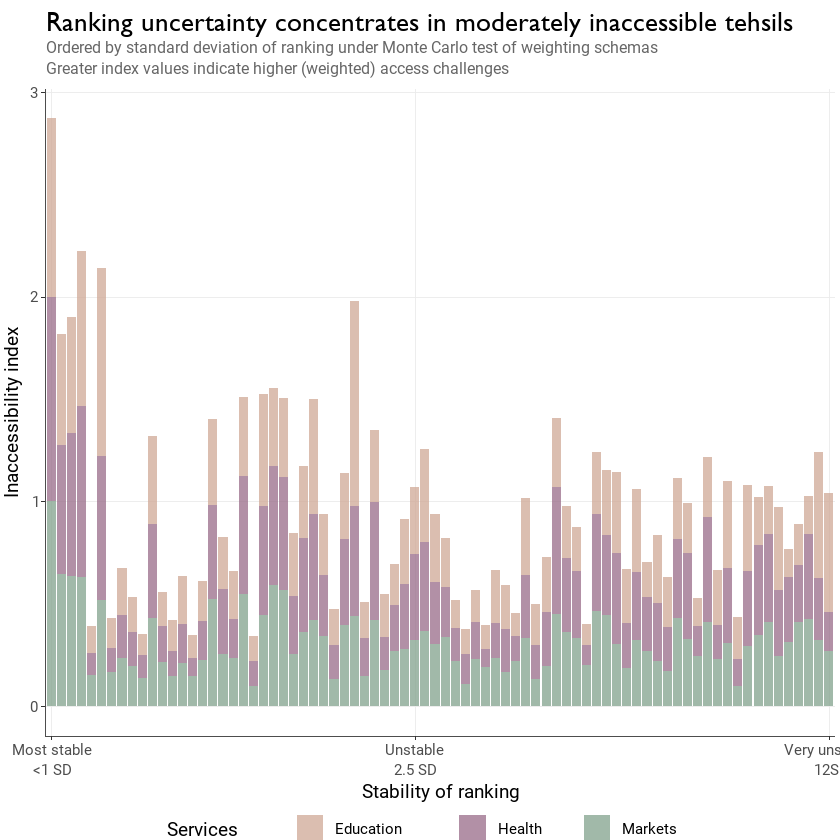

In [200]:
adm3_accmast_std_stackedbar <- ggplot(data = accmast_adm3_long) +
    geom_bar(aes(x=wtd_std_order, y = Index.values, fill=Access.indicators),alpha=0.75,position="stack",stat="identity") +
    labs(x="Stability of ranking",y="Inaccessibility index",
         title = "Ranking uncertainty concentrates in moderately inaccessible tehsils", 
         subtitle = "Ordered by standard deviation of ranking under Monte Carlo test of weighting schemas\nGreater index values indicate higher (weighted) access challenges",
         fill = "Services") +
    theme_access() +
    theme(legend.margin=margin(t=-5,b=-5)) +
#     scale_x_discrete(guide = guide_axis(angle=45)) +
    scale_x_discrete(breaks=c("Dassu","Sararogha","Shewa"),
                     labels=c("Most stable\n<1 SD","Unstable\n2.5 SD","Very unstable\n 12SD")) +
    scale_fill_manual(labels=c("Education","Health","Markets"),values=c("#cfa895","#986b88","#82a28c"))

adm3_accmast_std_stackedbar
ggsave(paste(data_dir,plot_dir,"\\adm3_accmast_std_stackedbar.png",sep=''),width=17,height=10,units=c("cm"),dpi=200)

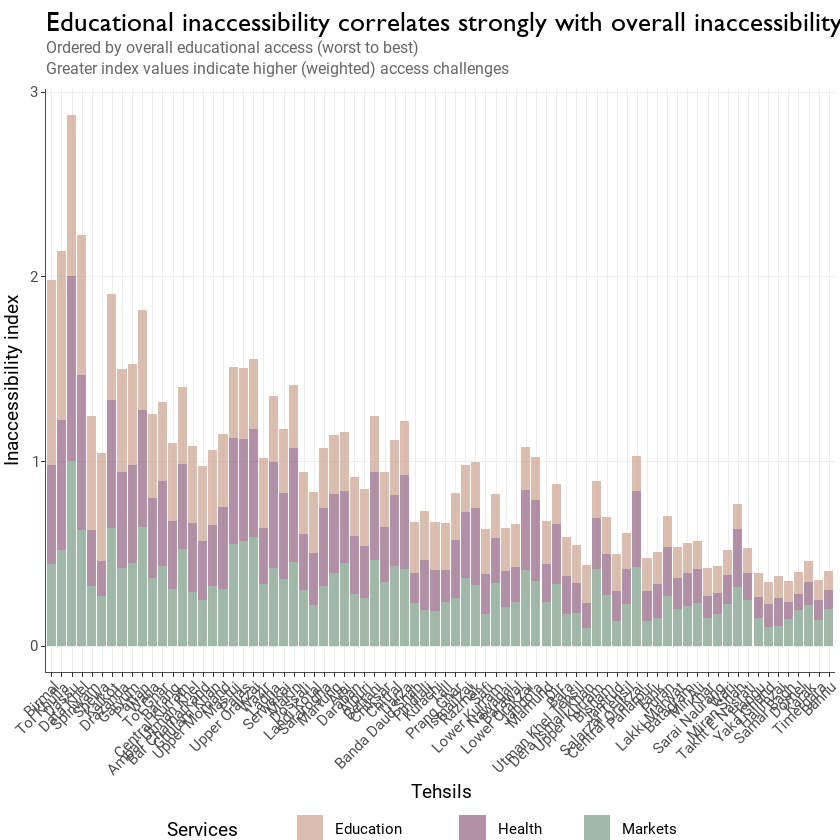

In [105]:
adm3_accmast_educ_stackedbar <- ggplot(data = accmast_adm3_long) +
    geom_bar(aes(x=educ_order, y = Index.values, fill=Access.indicators),alpha=0.75,position="stack",stat="identity") +
    labs(x="Tehsils",y="Inaccessibility index",
         title = "Educational inaccessibility correlates strongly with overall inaccessibility", 
         subtitle = "Ordered by overall educational access (worst to best)\nGreater index values indicate higher (weighted) access challenges",
         fill = "Services") +
    theme_access() +
    theme(legend.margin=margin(t=-5,b=-5)) +
    scale_x_discrete(guide = guide_axis(angle=45)) +
#     scale_x_discrete(breaks=c("Dassu","Sararogha","Shewa"),
#                      labels=c("Most stable\n<1 SD","Unstable\n2.5 SD","Very unstable\n 12SD")) +
    scale_fill_manual(labels=c("Education","Health","Markets"),values=c("#cfa895","#986b88","#82a28c"))

adm3_accmast_educ_stackedbar
ggsave(paste(data_dir,plot_dir,"\\adm3_accmast_educ_stackedbar.png",sep=''),width=17,height=10,units=c("cm"),dpi=200)

### Market access vs. farmland

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


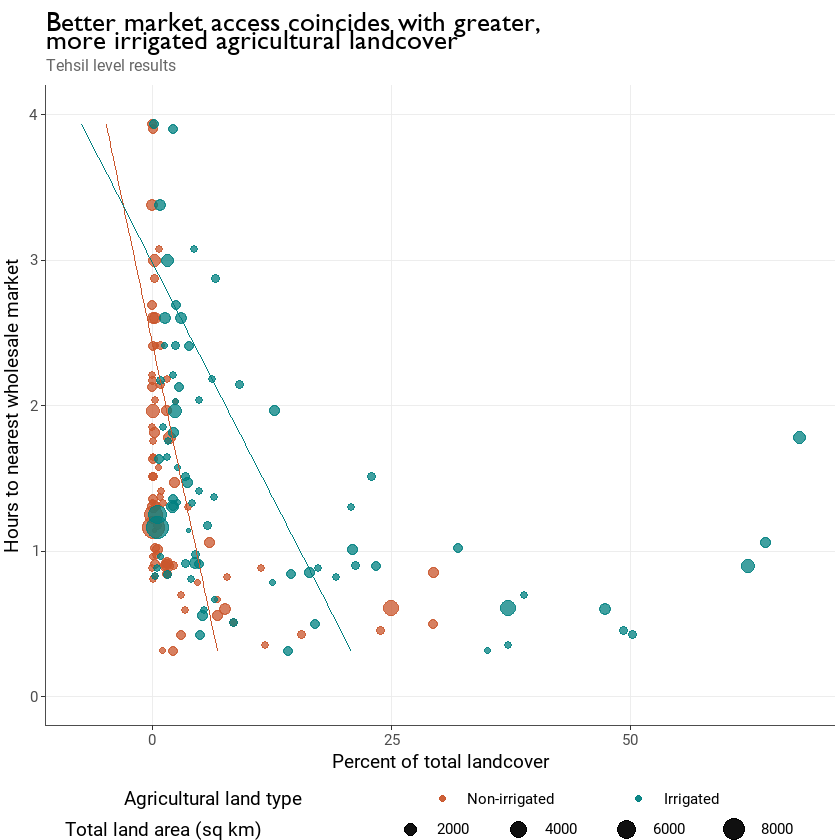

In [171]:
ag_irrig_lc_acc_plot <- ggplot(data = accmast_adm3) +
    geom_point(aes(x = dry_markets_All_avg_adm3, y = irrig_pct, size = area_sqkm, color = 'blue'),alpha=0.75) +
    geom_point(aes(x = dry_markets_All_avg_adm3, y = non_irrig_pct, size = area_sqkm, color = 'red'),alpha=0.75) +
    geom_smooth(method="lm", se=F, aes(x = dry_markets_All_avg_adm3, y = irrig_pct, color = 'blue'),alpha=0.5,size=0.35,show.legend=FALSE) +
    geom_smooth(method="lm", se=F, aes(x = dry_markets_All_avg_adm3, y = non_irrig_pct, color = 'red'),alpha=0.5,size=0.35,show.legend=FALSE) +
    labs(x="Hours to nearest wholesale market",y="Percent of total landcover",
         title = "Better market access coincides with greater,\nmore irrigated agricultural landcover", 
         subtitle = "Tehsil level results",
         color= "Agricultural land type",
         size = "Total land area (sq km)")+
    theme_access() +
    guides(color=guide_legend(nrow=1,byrow=TRUE),margin=0) +
#     scale_color_manual(labels=c("Non-irrigated","Irrigated"),values=c("#d46780","#798234")) +
    scale_color_manual(labels=c("Non-irrigated","Irrigated"),values=c("#ca562c","#008080","#ca562c","#008080")) +
    xlim(c(0,4)) +
    coord_flip()

ag_irrig_lc_acc_plot
ggsave(paste(data_dir,plot_dir,"\\agr_irrig_lc_acc_scatter.png",sep=''),width=12,height=10,units=c("cm"),dpi=200)

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."


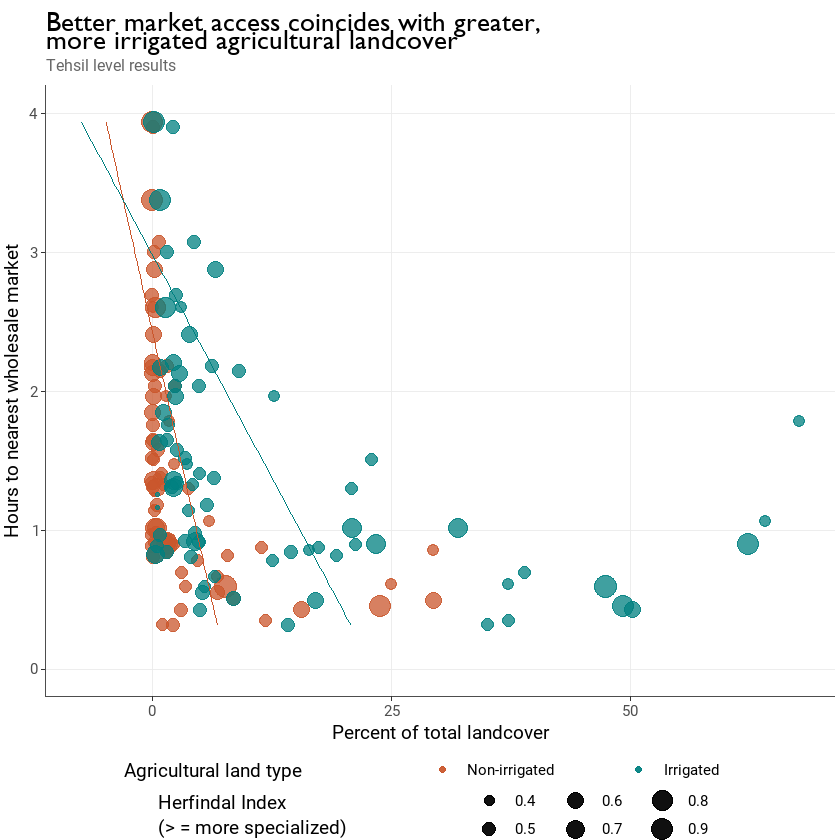

In [181]:
ag_irrig_lc_hindex_acc_plot <- ggplot(data = accmast_adm3) +
    geom_point(aes(x = dry_markets_All_avg_adm3, y = irrig_pct, size = h_index, color = 'blue'),alpha=0.75) +
    geom_point(aes(x = dry_markets_All_avg_adm3, y = non_irrig_pct, size = h_index, color = 'red'),alpha=0.75) +
    geom_smooth(method="lm", se=F, aes(x = dry_markets_All_avg_adm3, y = irrig_pct, color = 'blue'),alpha=0.5,size=0.35,show.legend=FALSE) +
    geom_smooth(method="lm", se=F, aes(x = dry_markets_All_avg_adm3, y = non_irrig_pct, color = 'red'),alpha=0.5,size=0.35,show.legend=FALSE) +
    labs(x="Hours to nearest wholesale market",y="Percent of total landcover",
         title = "Better market access coincides with greater,\nmore irrigated agricultural landcover", 
         subtitle = "Tehsil level results",
         color= "Agricultural land type",
         size = "Herfindal Index\n(> = more specialized)")+
    theme_access() +
    guides(color=guide_legend(nrow=1,byrow=TRUE),margin=0) +
#     scale_color_manual(labels=c("Non-irrigated","Irrigated"),values=c("#d46780","#798234")) +
    scale_color_manual(labels=c("Non-irrigated","Irrigated"),values=c("#ca562c","#008080","#ca562c","#008080")) +
    xlim(c(0,4)) +
    coord_flip()

ag_irrig_lc_hindex_acc_plot
ggsave(paste(data_dir,plot_dir,"\\agr_irrig_lc_herf_index_acc_scatter.png",sep=''),width=12,height=10,units=c("cm"),dpi=200)

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


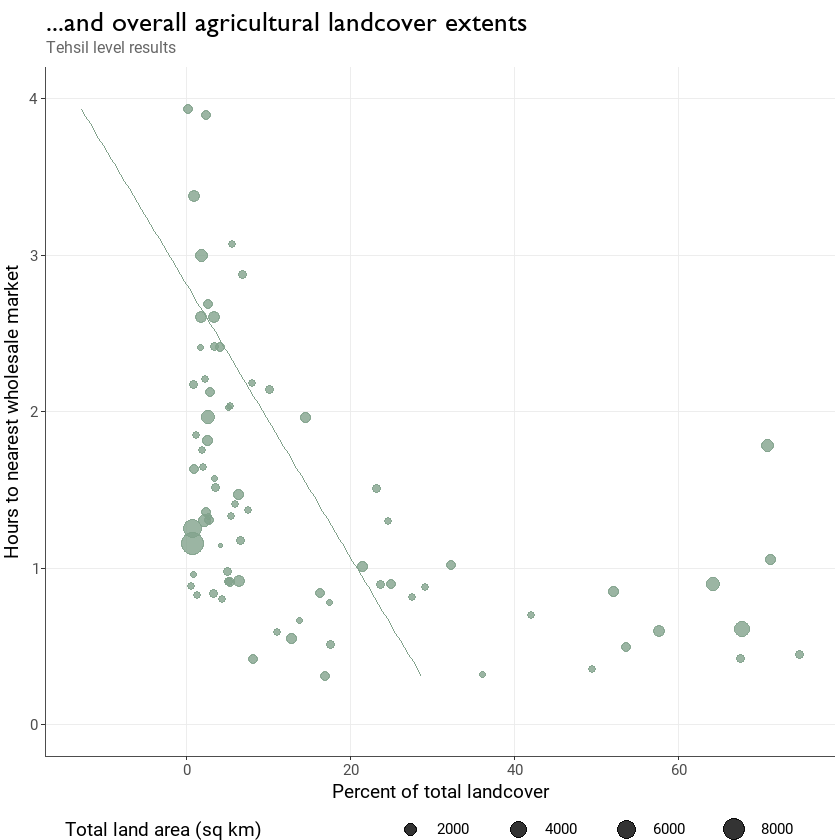

In [167]:
ag_all_lc_acc_plot <- ggplot(data = accmast_adm3) +
    geom_point(aes(x = dry_markets_All_avg_adm3, y = total_agr_pct, size = area_sqkm, color = 'blue'),alpha=0.8) +
    geom_smooth(method="lm", se=F, aes(x = dry_markets_All_avg_adm3, y = total_agr_pct, color = '#82a28c'),alpha=0.5,size=0.35,show.legend=FALSE) +
    labs(x="Hours to nearest wholesale market",y="Percent of total landcover",
         title = "...and overall agricultural landcover extents", 
         subtitle = "Tehsil level results", color = element_blank(),
         size = "Total land area (sq km)") +
    theme_access() +
#     theme(legend.position="none") +
#     guides(color=guide_legend(nrow=1,byrow=TRUE)) +
    scale_color_manual(values=c("#82a28c","#82a28c"),guide="none") +
    xlim(c(0,4)) +
    coord_flip()

ag_all_lc_acc_plot
ggsave(paste(data_dir,plot_dir,"\\agr_all_lc_acc_scatter.png",sep=''),width=12,height=10,units=c("cm"),dpi=200)

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."


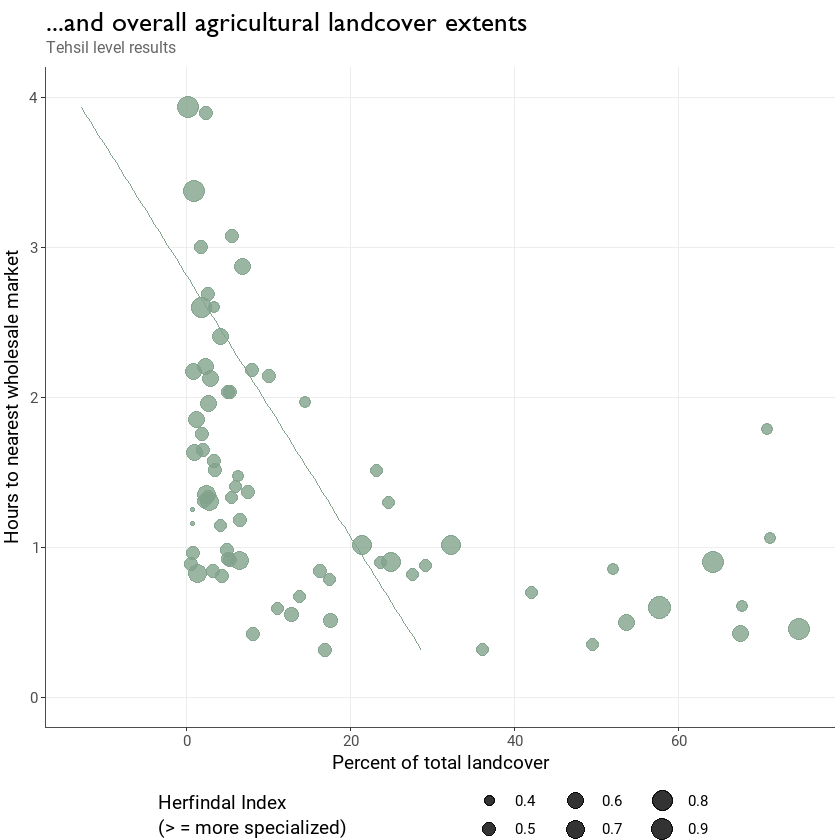

In [180]:
ag_all_lc_hindex_acc_plot <- ggplot(data = accmast_adm3) +
    geom_point(aes(x = dry_markets_All_avg_adm3, y = total_agr_pct, size = h_index, color = 'blue'),alpha=0.8) +
    geom_smooth(method="lm", se=F, aes(x = dry_markets_All_avg_adm3, y = total_agr_pct, color = '#82a28c'),alpha=0.5,size=0.35,show.legend=FALSE) +
    labs(x="Hours to nearest wholesale market",y="Percent of total landcover",
         title = "...and overall agricultural landcover extents", 
         subtitle = "Tehsil level results", color = element_blank(),
         size = "Herfindal Index\n(> = more specialized)") +
    theme_access() +
#     theme(legend.position="none") +
#     guides(color=guide_legend(nrow=1,byrow=TRUE)) +
    scale_color_manual(values=c("#82a28c","#82a28c"),guide="none") +
    xlim(c(0,4)) +
    coord_flip()

ag_all_lc_hindex_acc_plot
ggsave(paste(data_dir,plot_dir,"\\agr_all_lc_hindex_acc_scatter.png",sep=''),width=12,height=10,units=c("cm"),dpi=200)

Warning message:
"Removed 4 rows containing missing values (geom_point)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."


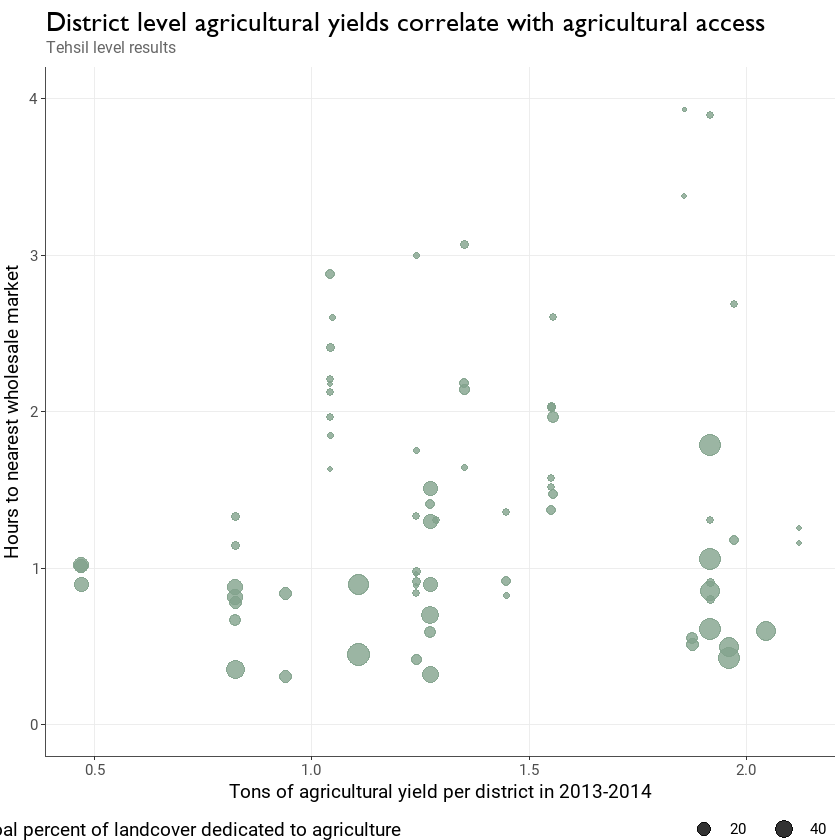

In [216]:
ag_all_lc_yield_acc_plot <- ggplot(data = accmast_adm3) +
    geom_point(aes(x = dry_markets_All_avg_adm3, y = yield_wt, size = total_agr_pct, color = 'blue'),alpha=0.8) +
#     geom_smooth(method="lm", se=F, aes(x = dry_markets_All_avg_adm3, y = yield_wt, size = total_agr_pct, color = '#82a28c'),alpha=0.5,size=0.35,show.legend=FALSE) +
    labs(x="Hours to nearest wholesale market",y="Tons of agricultural yield per district in 2013-2014",
         title = "District level agricultural yields correlate with agricultural access", 
         subtitle = "Tehsil level results", color = element_blank(),
         size = "Totoal percent of landcover dedicated to agriculture") +
    theme_access() +
#     theme(legend.position="none") +
#     guides(color=guide_legend(nrow=1,byrow=TRUE)) +
    scale_color_manual(values=c("#82a28c","#82a28c"),guide="none") +
    xlim(c(0,4)) +
    coord_flip()

ag_all_lc_yield_acc_plot
ggsave(paste(data_dir,plot_dir,"\\agr_all_lc_yield_acc_scatter.png",sep=''),width=12,height=10,units=c("cm"),dpi=200)

### Education general

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



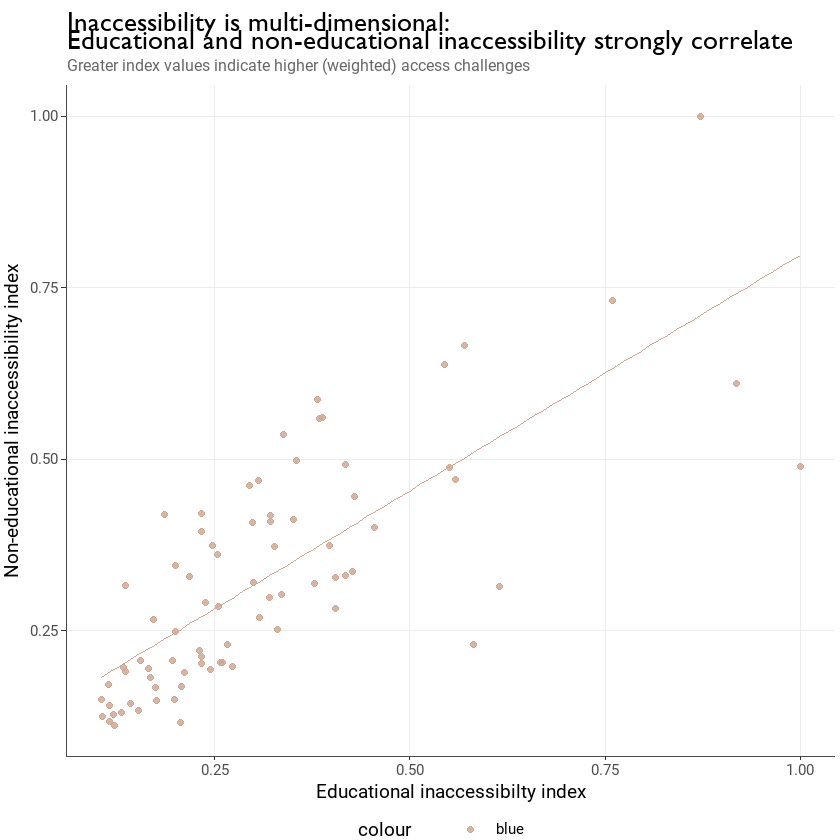

In [107]:
adm3_accmast_educ_pts <- ggplot(data = accmast_adm3) +
    geom_point(aes(x=educ_master, y = non_educ_master, color = 'blue'),alpha=0.85) +
    geom_smooth(method="lm", se=F, aes(x=educ_master, y = non_educ_master, color = 'blue'),alpha=0.5,size=0.5,show.legend=FALSE) +
    labs(x="Educational inaccessibilty index",y="Non-educational inaccessibility index",
         title = "Inaccessibility is multi-dimensional:\nEducational and non-educational inaccessibility strongly correlate", 
         subtitle = "Greater index values indicate higher (weighted) access challenges") +
    theme_access() +
    theme(legend.margin=margin(t=-5,b=-5)) +
    scale_color_manual(values=c("#cfa895"))
#     scale_x_discrete(guide = guide_axis(angle=45)) 
#     scale_x_discrete(breaks=c("Dassu","Sararogha","Shewa"),
#                      labels=c("Most stable\n<1 SD","Unstable\n2.5 SD","Very unstable\n 12SD")) +
#     scale_fill_manual(labels=c("Education","Health","Markets"),values=c("#cfa895","#986b88","#82a28c"))

adm3_accmast_educ_pts
ggsave(paste(data_dir,plot_dir,"\\adm3_accmast_educ_vs_other.png",sep=''),width=10.5,height=10,units=c("cm"),dpi=200)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



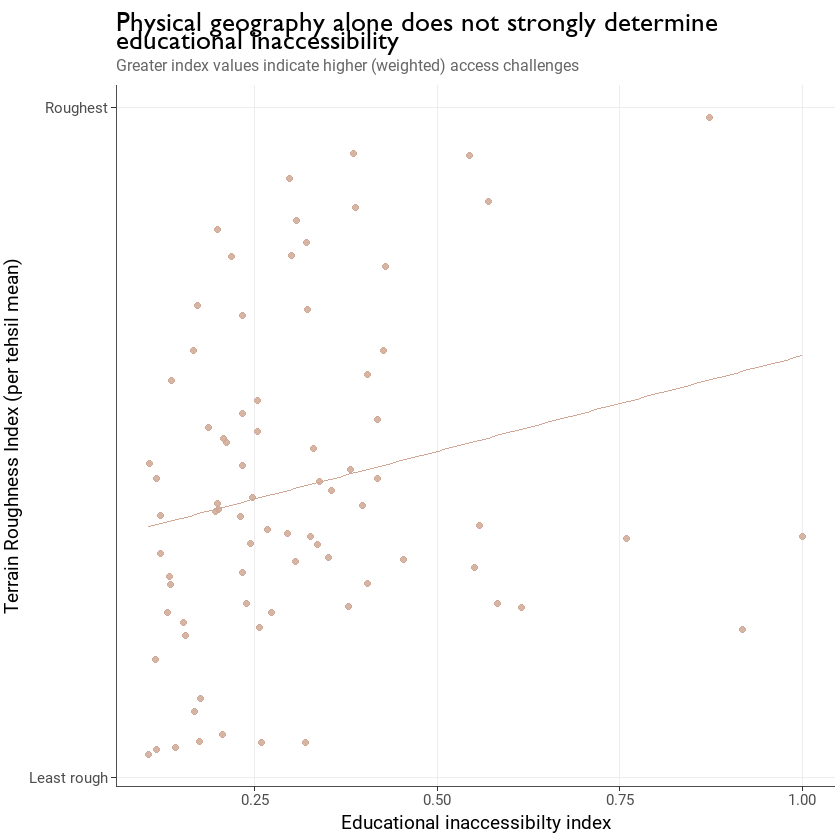

In [104]:
adm3_accmast_educ_TRI_pts <- ggplot(data = accmast_adm3) +
    geom_point(aes(x=educ_master, y = TRI, color = 'blue'),alpha=0.85,show.legend=FALSE) +
    geom_smooth(method="lm", se=F, aes(x=educ_master, y = TRI, color = 'blue'),alpha=0.5,size=0.5,show.legend=FALSE) +
    labs(x="Educational inaccessibilty index",y="Terrain Roughness Index (per tehsil mean)",
         title = "Physical geography alone does not strongly determine\neducational inaccessibility", 
         subtitle = "Greater index values indicate higher (weighted) access challenges") +
    theme_access() +
    theme(legend.margin=margin(t=-5,b=-5)) +
    scale_color_manual(values=c("#cfa895")) +
    scale_y_continuous(breaks=c(1,60),
                     labels = c("Least rough", "Roughest"))
#     scale_x_discrete(guide = guide_axis(angle=45)) 
#     scale_x_discrete(breaks=c("Dassu","Sararogha","Shewa"),
#                      labels=c("Most stable\n<1 SD","Unstable\n2.5 SD","Very unstable\n 12SD")) +
#     scale_fill_manual(labels=c("Education","Health","Markets"),values=c("#cfa895","#986b88","#82a28c"))

adm3_accmast_educ_TRI_pts
ggsave(paste(data_dir,plot_dir,"\\adm3_accmast_educ_TRI.png",sep=''),width=10,height=10,units=c("cm"),dpi=200)

In [99]:
# adm3_accmast_educ_std_pts <- ggplot(data = accmast_adm3) +
#     geom_point(aes(x=sens_test_rank_mean, y = educ_master),alpha=0.75) +
#     geom_smooth(method="lm", se=F, aes(x=sens_test_rank_mean, y = educ_master, color = 'blue'),alpha=0.5,size=0.5,show.legend=FALSE) +
#     labs(x="Mean ranking (500K weighting schemas)",y="Educational inaccessibilty index",
#          title = "Inaccessibility is multi-dimensional:\nEducational inaccessibility correlates strongly with other with overall inaccessibility", 
#          subtitle = "Greater index values indicate higher (weighted) access challenges") +
#     theme_access() +
#     theme(legend.margin=margin(t=-5,b=-5)) +
#     scale_color_manual(values=c("#cfa895"))
# #     scale_x_discrete(guide = guide_axis(angle=45)) 
# #     scale_x_discrete(breaks=c("Dassu","Sararogha","Shewa"),
# #                      labels=c("Most stable\n<1 SD","Unstable\n2.5 SD","Very unstable\n 12SD")) +
# #     scale_fill_manual(labels=c("Education","Health","Markets"),values=c("#cfa895","#986b88","#82a28c"))

# adm3_accmast_educ_std_pts
# ggsave(paste(data_dir,plot_dir,"\\adm3_accmast_educ_std.png",sep=''),width=17,height=10,units=c("cm"),dpi=200)

### Girls vs. boys schooling

Overall gender differences

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 2 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 2 rows containing missing values (geom_point)."


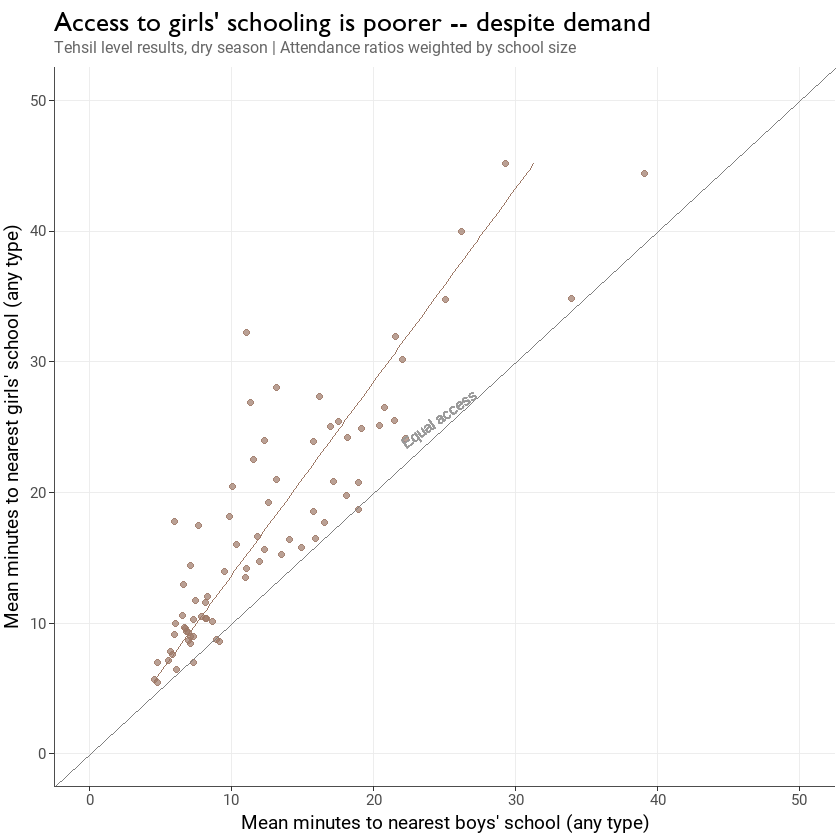

In [172]:
fem_v_male_educ_acc_plot <- ggplot(data = accmast_adm3) +
    geom_point(aes(x = (dry_education_girls_avg_adm3*60), y = (dry_education_boys_avg_adm3*60), size = Boys_schools, color = '#9c7765'),alpha=0.7) +
    scale_size(range = c(.4,2)) +
    geom_smooth(method="lm", se=F, aes(x = (dry_education_girls_avg_adm3*60), y = (dry_education_boys_avg_adm3*60), color = '#9c7765'),alpha=0.5,size=0.35,show.legend=FALSE) +
    labs(x="Mean minutes to nearest girls' school (any type)",y="Mean minutes to nearest boys' school (any type)",
         title = "Access to girls' schooling is poorer -- despite demand", 
         subtitle = "Tehsil level results, dry season | Attendance ratios weighted by school size") +
    theme_access() +
    theme(legend.title = element_text(lineheight=0.5)) +
    scale_color_manual(values="#9c7765") +
    labs(size =  "Boys/girls attendance ratio\nin nominally boys' schools") +
    guides(colour="none",
           label.position="bottom",
           title.position = "left", title.hjust = 2) +
    geom_abline(intercept = 0, slope = 1, color = 'grey50', size = 0.5) +
    geom_text(aes(25,25,alpha=0.5),label = "Equal access", hjust=0.5, vjust = -0.5,angle=35.5, color = 'grey60', show.legend=FALSE) +
    xlim(c(0,50)) +
    ylim(c(0,50)) +
    coord_flip()

fem_v_male_educ_acc_plot
ggsave(paste(data_dir,plot_dir,"\\fem_v_male_educ_acc.png",sep=''),width=10,height=10,units=c("cm"),dpi=200)

Primary

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 4 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 4 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."


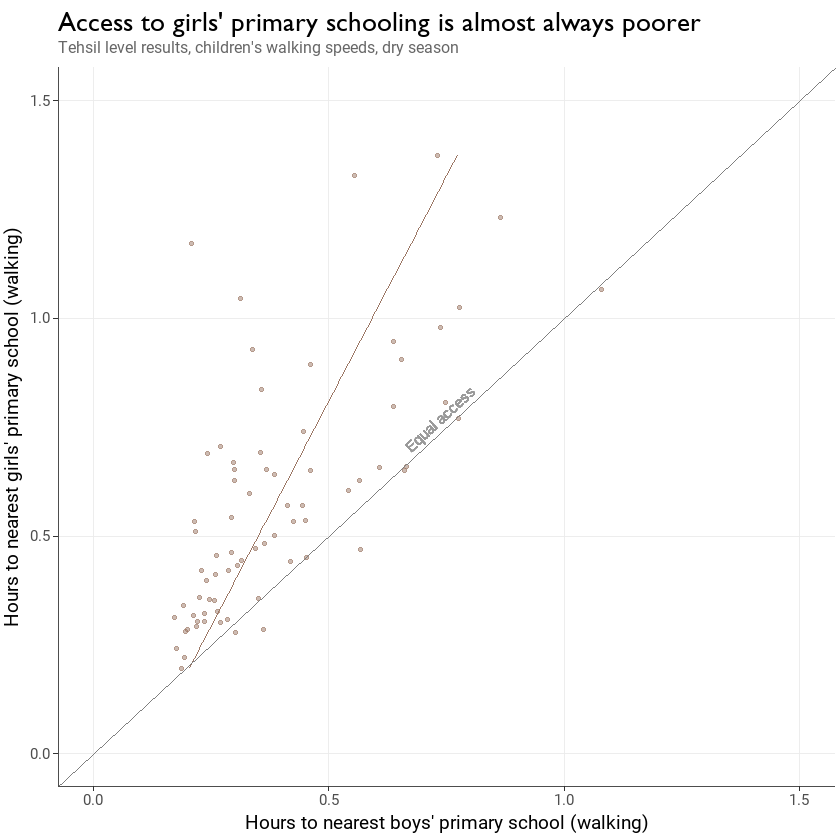

In [175]:
fem_v_male_educ_walk_primary_acc_plot <- ggplot(data = accmast_adm3) +
    geom_point(aes(x = childwalk_dry_education_girls_primary_avg_adm3, y = childwalk_dry_education_boys_primary_avg_adm3, color = 'dry'),alpha=0.5,size=1) +
    geom_smooth(method="lm", se=F, aes(x = childwalk_dry_education_girls_primary_avg_adm3, y = childwalk_dry_education_boys_primary_avg_adm3, color = 'dry',alpha=0.5),size=0.35) +
    labs(x="Hours to nearest girls' primary school (walking)",y="Hours to nearest boys' primary school (walking)",
         title = "Access to girls' primary schooling is almost always poorer", 
         subtitle = "Tehsil level results, children's walking speeds, dry season") +
    theme_access() +
    theme(legend.position="none") +
    scale_color_manual(labels=c("Agricultural land"),values=c("#9c7765")) +
#     scale_color_manual(labels=c("Dry","Monsoon","Winter"),values=c("#ca562c","grey40","#008080")) +
    geom_abline(intercept = 0, slope = 1, color = 'grey50', size = 0.5) +
    geom_text(aes(0.75,0.75,alpha=0.5),label = "Equal access", hjust=0.5, vjust = -0.5,angle=42.5, color = 'grey60') +
    xlim(c(0,1.5)) +
    ylim(c(0,1.5)) +
    coord_flip()

fem_v_male_educ_walk_primary_acc_plot
ggsave(paste(data_dir,plot_dir,"\\fem_v_male_educ_walking_primary_acc.png",sep=''),width=10,height=10,units=c("cm"),dpi=200)

Middle

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



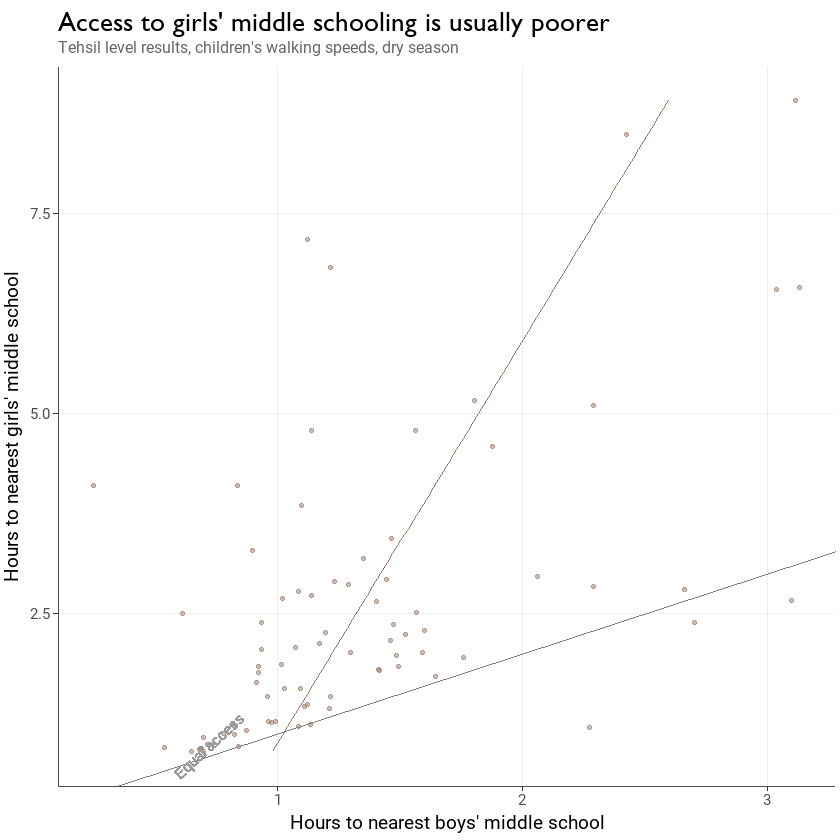

In [125]:
fem_v_male_educ_walk_middle_acc_plot <- ggplot(data = accmast_adm3) +
    geom_point(aes(x = childwalk_dry_education_girls_middle_avg_adm3, y = childwalk_dry_education_boys_middle_avg_adm3, color = 'dry'),alpha=0.5,size=1) +
    geom_smooth(method="lm", se=F, aes(x = childwalk_dry_education_girls_middle_avg_adm3, y = childwalk_dry_education_boys_middle_avg_adm3, color = 'dry',alpha=0.5),size=0.35) +
    labs(x="Hours to nearest girls' middle school",y="Hours to nearest boys' middle school",
         title = "Access to girls' middle schooling is usually poorer", 
         subtitle = "Tehsil level results, children's walking speeds, dry season") +
    theme_access() +
    theme(legend.position="none") +
    scale_color_manual(labels=c("Agricultural land"),values=c("#9c7765")) +
#     scale_color_manual(labels=c("Dry","Monsoon","Winter"),values=c("#ca562c","grey40","#008080")) +
    geom_abline(intercept = 0, slope = 1, color = 'grey50', size = 0.5) +
    geom_text(aes(0.75,0.75,alpha=0.5),label = "Equal access", hjust=0.5, vjust = -0.5,angle=42.5, color = 'grey60') +
#     xlim(c(0,1.5)) +
#     ylim(c(0,1.5)) +
    coord_flip()

fem_v_male_educ_walk_middle_acc_plot
ggsave(paste(data_dir,plot_dir,"\\fem_v_male_educ_walking_middle_acc.png",sep=''),width=10,height=10,units=c("cm"),dpi=200)

High

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



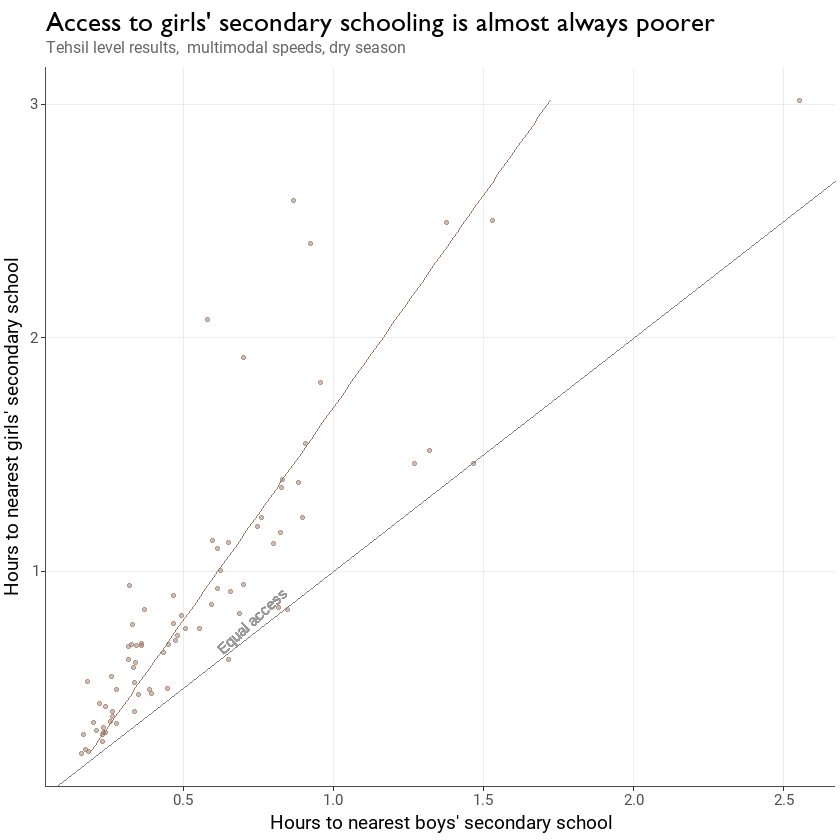

In [137]:
fem_v_male_educ_walk_high_acc_plot <- ggplot(data = accmast_adm3) +
    geom_point(aes(x = dry_education_girls_high_avg_adm3, y = dry_education_boys_high_avg_adm3, color = 'dry'),alpha=0.5,size=1) +
    geom_smooth(method="lm", se=F, aes(x = dry_education_girls_high_avg_adm3, y = dry_education_boys_high_avg_adm3, color = 'dry',alpha=0.5),size=0.35) +
    labs(x="Hours to nearest girls' secondary school",y="Hours to nearest boys' secondary school",
         title = "Access to girls' secondary schooling is almost always poorer", 
         subtitle = "Tehsil level results,  multimodal speeds, dry season") +
    theme_access() +
    theme(legend.position="none") +
    scale_color_manual(labels=c("Agricultural land"),values=c("#9c7765")) +
#     scale_color_manual(labels=c("Dry","Monsoon","Winter"),values=c("#ca562c","grey40","#008080")) +
    geom_abline(intercept = 0, slope = 1, color = 'grey50', size = 0.5) +
    geom_text(aes(0.75,0.75,alpha=0.5),label = "Equal access", hjust=0.5, vjust = -0.5,angle=42.5, color = 'grey60') +
#     xlim(c(0,1.5)) +
#     ylim(c(0,1.5)) +
    coord_flip()

fem_v_male_educ_walk_high_acc_plot
ggsave(paste(data_dir,plot_dir,"\\fem_v_male_educ_walking_high_acc.png",sep=''),width=10,height=10,units=c("cm"),dpi=200)

All

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



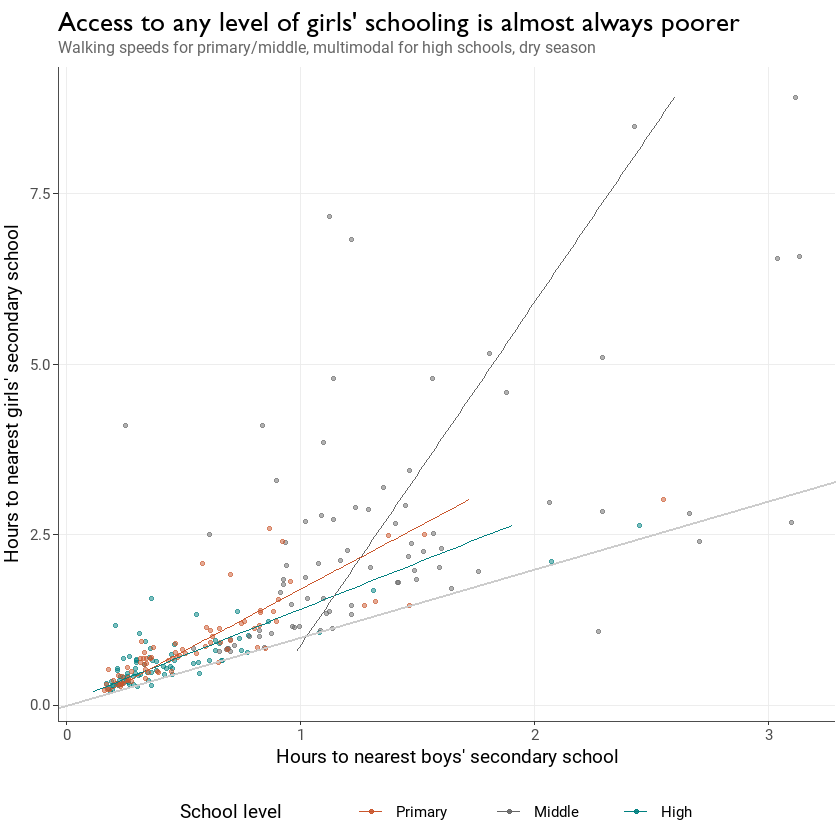

In [149]:
fem_v_male_educ_all_acc_plot <- ggplot(data = accmast_adm3) +
    geom_point(aes(x = childwalk_dry_education_girls_primary_avg_adm3, y = childwalk_dry_education_boys_primary_avg_adm3, color = 'primary'),alpha=0.5,size=1) +
    geom_point(aes(x = childwalk_dry_education_girls_middle_avg_adm3, y = childwalk_dry_education_boys_middle_avg_adm3, color = 'middle'),alpha=0.5,size=1) +
    geom_point(aes(x = dry_education_girls_high_avg_adm3, y = dry_education_boys_high_avg_adm3, color = 'high'),alpha=0.5,size=1) +
    geom_smooth(method="lm", se=F, aes(x = childwalk_dry_education_girls_primary_avg_adm3, y = childwalk_dry_education_boys_primary_avg_adm3, color = 'primary'),alpha=0.5,size=0.35) +
    geom_smooth(method="lm", se=F, aes(x = childwalk_dry_education_girls_middle_avg_adm3, y = childwalk_dry_education_boys_middle_avg_adm3, color = 'middle'),alpha=0.5,size=0.35) +
    geom_smooth(method="lm", se=F, aes(x = dry_education_girls_high_avg_adm3, y = dry_education_boys_high_avg_adm3, color = 'high'),alpha=0.5,size=0.35) +
    labs(x="Hours to nearest girls' secondary school",y="Hours to nearest boys' secondary school",
         title = "Access to any level of girls' schooling is almost always poorer", 
         subtitle = "Walking speeds for primary/middle, multimodal for high schools, dry season",
         color = "School level") +
    theme_access() +
#     theme(legend.position="none") +
    scale_alpha_manual(values="whatever",guide="none") +
    scale_color_manual(labels=c("Primary","Middle","High"),values=c("#ca562c","grey40","#008080")) +
    geom_abline(intercept = 0, slope = 1, color = 'grey80', size = 0.6) +
#     geom_text(aes(0.75,0.75,alpha=0.5),label = "Equal access", hjust=0.5, vjust = -0.5,angle=42.5, color = 'grey60') +
#     xlim(c(0,1.5)) +
#     ylim(c(0,1.5)) +
    coord_flip()

fem_v_male_educ_all_acc_plot
ggsave(paste(data_dir,plot_dir,"\\fem_v_male_educ_all_acc.png",sep=''),width=10,height=10,units=c("cm"),dpi=200)

#### Dif charts

Versus poverty

Warning message:
"Removed 10 rows containing missing values (geom_point)."
Warning message:
"Removed 10 rows containing missing values (geom_point)."


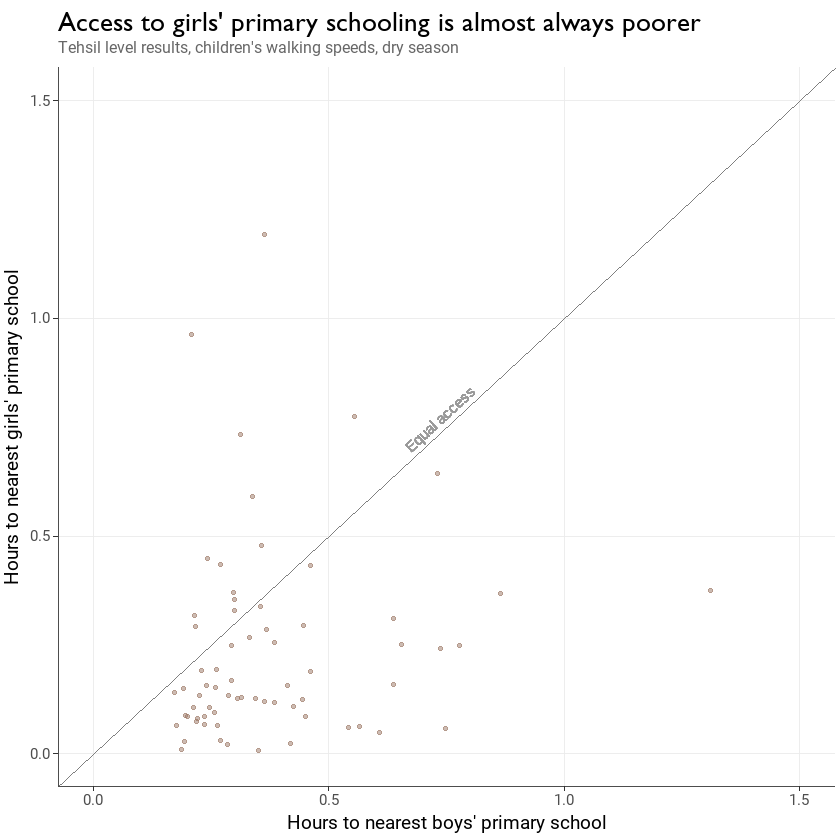

In [151]:
fem_v_male_educ_walk_primary_acc_plot <- ggplot(data = accmast_adm3) +
    geom_point(aes(x = childwalk_dry_educ_primary_gender_dif, y = childwalk_dry_education_boys_primary_avg_adm3, color = 'dry'),alpha=0.5,size=1) +
#     geom_smooth(method="lm", se=F, aes(x = childwalk_dry_education_girls_primary_avg_adm3, y = childwalk_dry_education_boys_primary_avg_adm3, color = 'dry',alpha=0.5),size=0.35) +
    labs(x="Hours to nearest girls' primary school",y="Hours to nearest boys' primary school",
         title = "Access to girls' primary schooling is almost always poorer", 
         subtitle = "Tehsil level results, children's walking speeds, dry season") +
    theme_access() +
    theme(legend.position="none") +
    scale_color_manual(labels=c("Agricultural land"),values=c("#9c7765")) +
#     scale_color_manual(labels=c("Dry","Monsoon","Winter"),values=c("#ca562c","grey40","#008080")) +
    geom_abline(intercept = 0, slope = 1, color = 'grey50', size = 0.5) +
    geom_text(aes(0.75,0.75,alpha=0.5),label = "Equal access", hjust=0.5, vjust = -0.5,angle=42.5, color = 'grey60') +
    xlim(c(0,1.5)) +
    ylim(c(0,1.5)) +
    coord_flip()

fem_v_male_educ_walk_primary_acc_plot
ggsave(paste(data_dir,plot_dir,"\\fem_v_male_educ_walking_primary_acc.png",sep=''),width=10,height=10,units=c("cm"),dpi=200)

Seasonal

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 2 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Wa

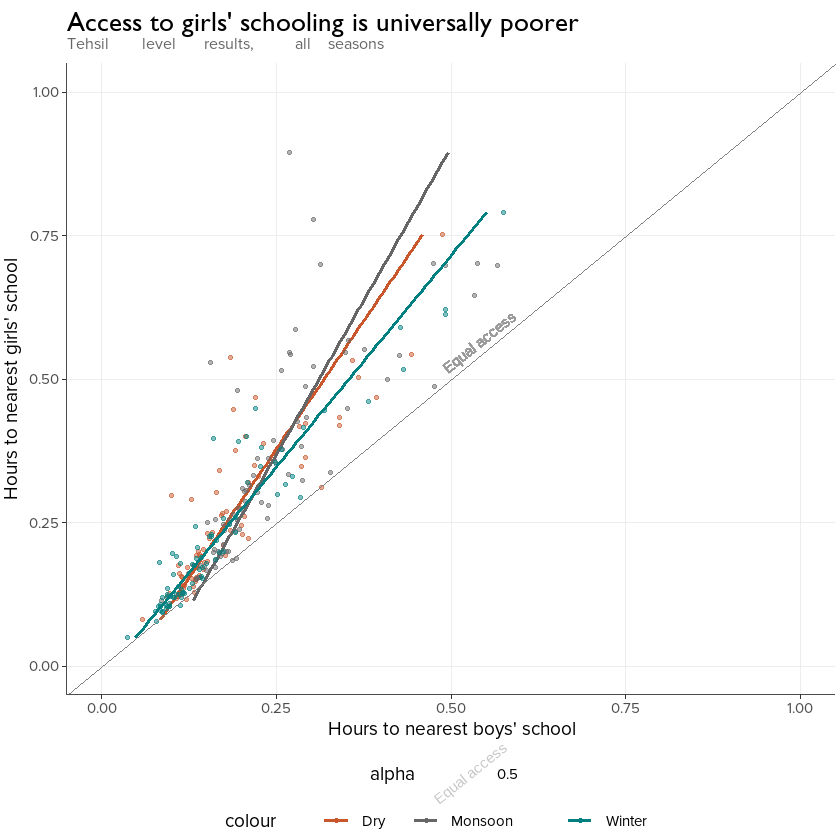

In [382]:
fem_v_male_seasons_educ_acc_plot <- ggplot(data = accm_adm3) +
    geom_point(aes(x = dry_education_girls_avg_adm3, y = dry_education_boys_avg_adm3, color = 'dry'),alpha=0.5,size=1) +
    geom_smooth(method="lm", se=F, aes(x = dry_education_girls_avg_adm3, y = dry_education_boys_avg_adm3, color = 'dry'),alpha=0.5,size=1) +
    geom_point(aes(x = msn_education_girls_avg_adm3, y = msn_education_boys_avg_adm3, color = 'msn'),alpha=0.5,size=1) +
    geom_smooth(method="lm", se=F, aes(x = msn_education_girls_avg_adm3, y = msn_education_boys_avg_adm3, color = 'msn'),alpha=0.5,size=1) +
    geom_point(aes(x = winter_education_girls_avg_adm3, y = winter_education_boys_avg_adm3, color = 'winter'),alpha=0.5,size=1) +
    geom_smooth(method="lm", se=F, aes(x = winter_education_girls_avg_adm3, y = winter_education_boys_avg_adm3, color = 'winter'),alpha=0.5,size=1) +
    labs(x="Hours to nearest girls' school",y="Hours to nearest boys' school",
         title = "Access to girls' schooling is universally poorer", 
         subtitle = "Tehsil level results, all seasons") +
    theme_access() +
#     theme(legend.position="none") +
#     scale_color_manual(labels=c("Non-irrigated","Irrigated"),values=c("#d46780","#798234")) +
    scale_color_manual(labels=c("Dry","Monsoon","Winter"),values=c("#ca562c","grey40","#008080")) +
    geom_text(aes(0.55,0.55,alpha=0.5),label = "Equal access", hjust=0.5, vjust = -0.5,angle=38.5, color = 'grey60') +
    geom_abline(intercept = 0, slope = 1, color = 'grey50', size = 0.5) +
    xlim(c(0,1)) +
    ylim(c(0,1)) +
    coord_flip()

fem_v_male_seasons_educ_acc_plot
ggsave(paste(data_dir,plot_dir,"\\fem_v_male_seasonal_educ_acc.png",sep=''),width=12,height=12,units=c("cm"),dpi=200)

### Healthcare

Overall

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 2 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 2 rows containing missing values (geom_point)."


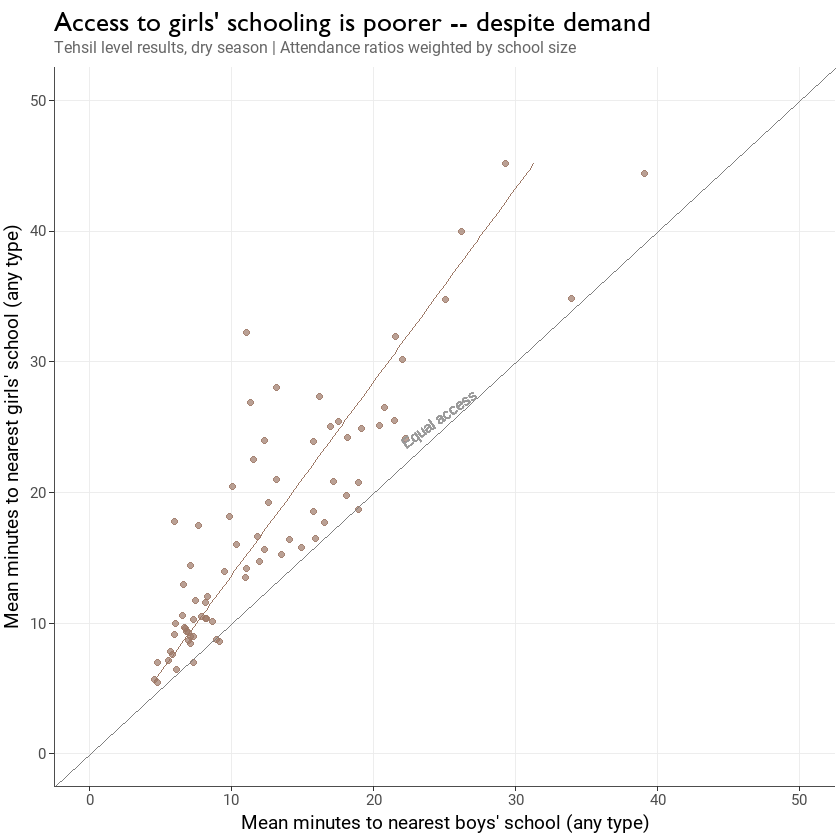

In [172]:
fem_v_male_educ_acc_plot <- ggplot(data = accmast_adm3) +
    geom_point(aes(x = (dry_education_girls_avg_adm3*60), y = (dry_education_boys_avg_adm3*60), size = Boys_schools, color = '#9c7765'),alpha=0.7) +
    scale_size(range = c(.4,2)) +
    geom_smooth(method="lm", se=F, aes(x = (dry_education_girls_avg_adm3*60), y = (dry_education_boys_avg_adm3*60), color = '#9c7765'),alpha=0.5,size=0.35,show.legend=FALSE) +
    labs(x="Mean minutes to nearest girls' school (any type)",y="Mean minutes to nearest boys' school (any type)",
         title = "Access to girls' schooling is poorer -- despite demand", 
         subtitle = "Tehsil level results, dry season | Attendance ratios weighted by school size") +
    theme_access() +
    theme(legend.title = element_text(lineheight=0.5)) +
    scale_color_manual(values="#9c7765") +
    labs(size =  "Boys/girls attendance ratio\nin nominally boys' schools") +
    guides(colour="none",
           label.position="bottom",
           title.position = "left", title.hjust = 2) +
    geom_abline(intercept = 0, slope = 1, color = 'grey50', size = 0.5) +
    geom_text(aes(25,25,alpha=0.5),label = "Equal access", hjust=0.5, vjust = -0.5,angle=35.5, color = 'grey60', show.legend=FALSE) +
    xlim(c(0,50)) +
    ylim(c(0,50)) +
    coord_flip()

fem_v_male_educ_acc_plot
ggsave(paste(data_dir,plot_dir,"\\fem_v_male_educ_acc.png",sep=''),width=10,height=10,units=c("cm"),dpi=200)

## Experimental

### Per admin bar charts

In [143]:
bar_plots <- lapply(adm2s, function(adm2) {

ggplot(data=accl_adm2[accl_adm2[,"Adm2_Code"] == adm2,], aes(x = travel_time_range, y = pop_pct)) +
    geom_text(aes(label=paste((pop_pct*100),"%\n",pop_total," persons",sep="")),hjust=-0.1,size=2.5) +
    theme(axis.text.y = element_text(angle=45, hjust=1),
          panel.grid.major.x = element_line(color="#ffffff", size=0.15,lineend="round"),
          panel.grid.major.y = element_blank(), legend.position="none") + 
    scale_y_continuous(limits=c(0,1),labels = scales::percent) +
    ylab("% of district population") +
    xlab("Travel time to nearest service") +
    stat_summary(fun="identity",geom="bar") +
    coord_flip()

    })

In [24]:
head(accl_adm2[accl_adm2[,"Adm2_Code"] == "PK243",])

,Adm2_Code,indicator,travel_time_range,pop_pct,pop_total
,<fct>,<fct>,<fct>,<dbl>,<chr>
17473,PK243,dry_District_HQs,0 - 30 minutes,0.000000000,0
17474,PK243,dry_District_HQs,31 - 60 minutes,0.007748164,361
17475,PK243,dry_District_HQs,1 - 2 hours,0.495043187,"23,034"
17476,PK243,dry_District_HQs,2 - 4 hours,0.492885095,"22,934"
17477,PK243,dry_District_HQs,4 - 8 hours,0.000000000,0
17478,PK243,dry_District_HQs,8 - 16 hours,0.004323553,201


In [17]:
# bar_plots

In [30]:
t <- dplyr::filter(accl_adm2,(Adm2_Code == 'PK243') & (indicator=='dry_District_HQs'))

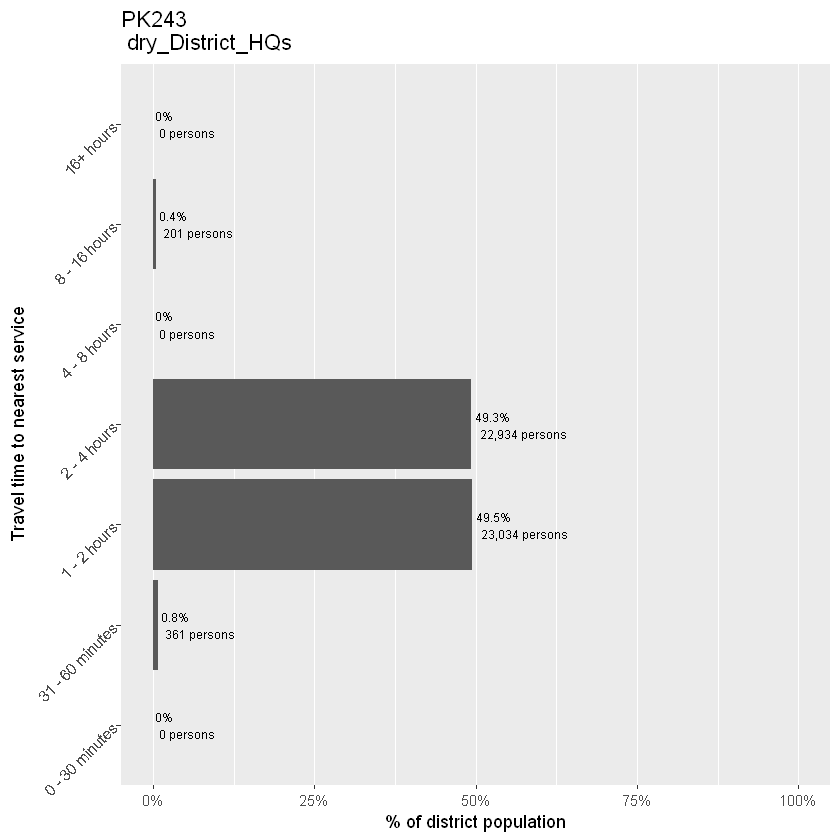

In [33]:
ggplot(t, aes(x = travel_time_range, y = pop_pct)) +
    geom_text(aes(label=paste(round((pop_pct*100),1),"%\n",pop_total," persons",sep="")),hjust=-0.1,size=2.5) +
    ggtitle(paste(t$Adm2_Code,"\n",t$indicator)) +
    theme(axis.text.y = element_text(angle=45, hjust=1),
          panel.grid.major.x = element_line(color="#ffffff", size=0.15,lineend="round"),
          panel.grid.major.y = element_blank(), legend.position="none") + 
    scale_y_continuous(limits=c(0,1),labels = scales::percent) +
    ylab("% of district population") +
    xlab("Travel time to nearest service") +
    stat_summary(fun="identity",geom="bar") +
    coord_flip()

### Scatterplot + line plot

In [18]:
indicators <- levels(accl_adm2$indicator)

In [19]:
colnames(accl_adm3)

[1] "Adm3_Code"         "indicator"         "travel_time_range"
[4] "pop_pct"           "pop_total"         "Adm2_Code"

In [27]:
scatter_adm2 <- lapply(indicators, function(indic) {

    ggplot(data= accl_adm3[accl_adm3[,"indicator"]==indic,], aes(x=travel_time_range,y=pop_pct,color=travel_time_range)) +
    geom_point(position = position_dodge(width=1), alpha=0.3,size=3) +
    geom_line(data = adm2_cumsum[adm2_cumsum[,"indicator"]==indic,], aes(x=travel_time_range, y=pop_pct_csum, group=Adm2_Code),size=1) +
    ggtitle(paste("Travel time to nearest",indic)) +
    theme(axis.text.x = element_text(angle=45, hjust=1),
          axis.title.x = element_blank()) +
    xlab("Average travel time to nearest facility") +
    ylab("% of Tehsil population in each travel time range") +
    scale_color_manual(values = army_rose_colors) +
    scale_y_continuous(limits=c(0,1),labels=scales::percent) +
    scale_x_discrete(breaks=c("0 to 30 minutes","1 to 2 hours","4 to 8 hours","16 to 32 hours"))
    })

Warning message:
"Removed 84 row(s) containing missing values (geom_path)."


[[1]]


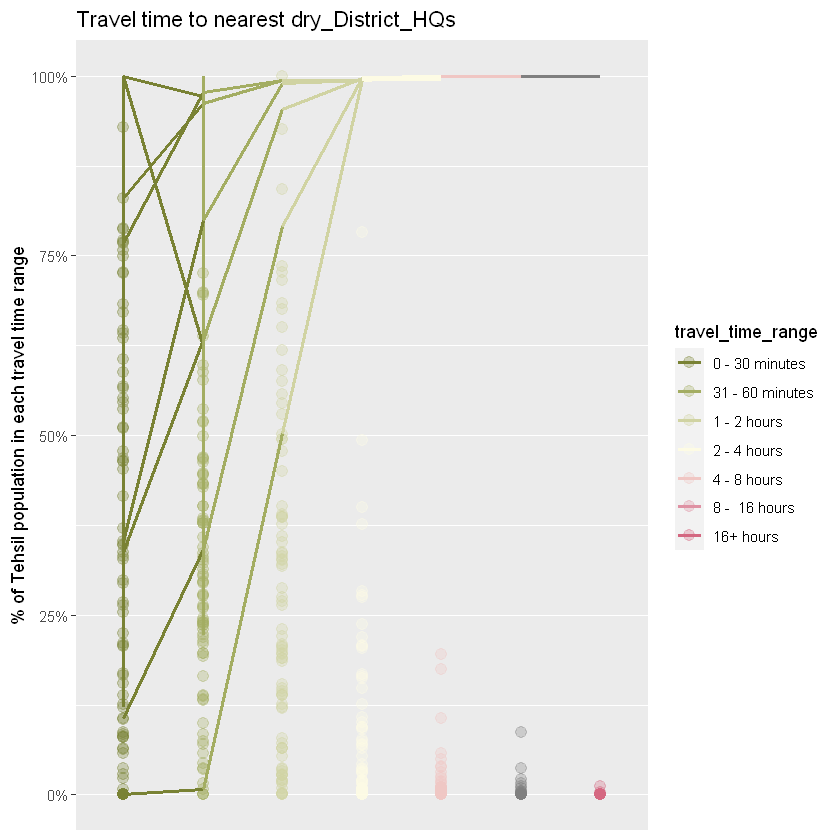

In [29]:
scatter_adm2[1]

Single chart example

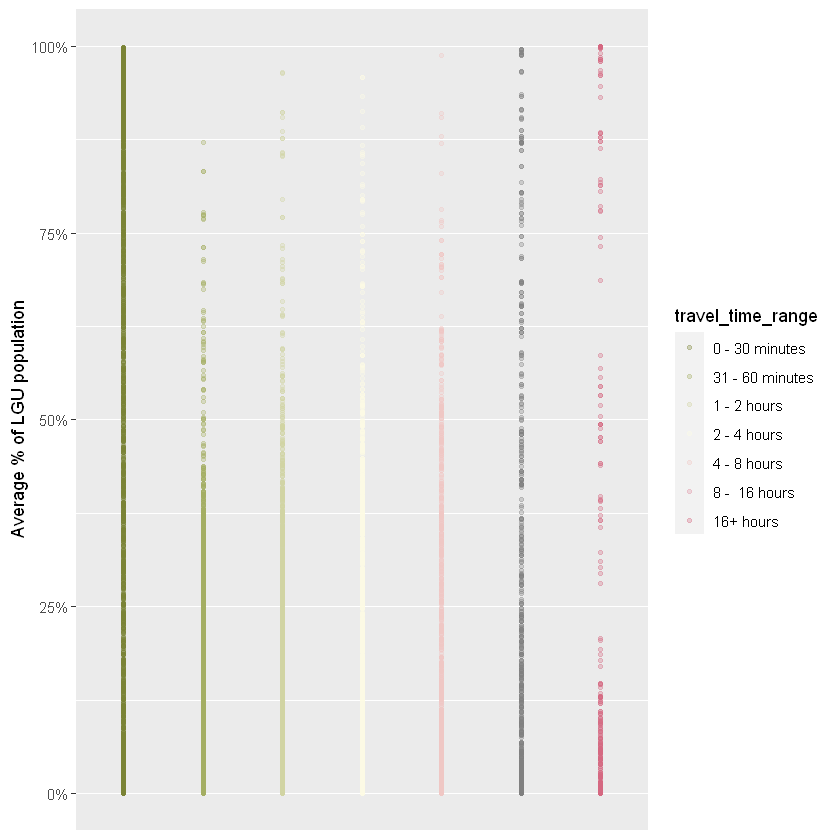

In [41]:
ggplot(accl_adm2, aes(x=travel_time_range,y=pop_pct,color=travel_time_range)) +
    geom_point(position = position_dodge(width=0.8), alpha=0.3,size=1) +
#     geom_line(aes(group = Adm2_Code),size=1) +
    theme(axis.text.x = element_text(angle=45, hjust=1),axis.title.x=element_blank()) +
    xlab("Average travel time to nearest facility") +
    ylab("Average % of LGU population") +
    scale_color_manual(values = army_rose_colors) +
    scale_y_continuous(limits=c(0,1),labels=scales::percent) +
    scale_x_discrete(breaks=c("0 to 30 minutes","1 to 2 hours","4 to 8 hours","16 to 32 hours"))